In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn


In [2]:
%load_ext google.cloud.bigquery

# Data Preparation

**First: conversion REG**

In [164]:
%%bigquery ga_last_touch

WITH reg AS(
              SELECT 
                DISTINCT full_visitor_id, organization_uuid , country_id , 
                session_id , session_start_time , session_end_time ,
                traffic_source_level_2 , traffic_source_level_3
              FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
              WHERE session_reached_minimal_page_visit IS True
              AND session_reached_minimal_created IS True
              ORDER BY full_visitor_id , organization_uuid , session_start_time 
)
SELECT 
  reg.full_visitor_id ,
  reg.organization_uuid ,
  reg.country_id AS ga_country,
  oc.country_id as country_id,
  reg.session_id,
  reg.session_start_time ,
  reg.session_end_time ,
  oc.organization_created ,
  reg.traffic_source_level_2 ,
  reg.traffic_source_level_3 
FROM reg
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON reg.organization_uuid = oc.organization_uuid
WHERE ((oc.organization_created BETWEEN session_start_time AND session_end_time) OR organization_created IS NULL)
ORDER BY full_visitor_id , organization_uuid , reg.session_start_time 

Merchants without cookies acceptance at registration are not recorded in ga data.

In [165]:
ga_last_touch.head()

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3
0,1000010740411935385,f4e1d400-a89a-11e7-9f2a-dbfd5c91c102,BR,BR,b'\xec\x95\x05)\xd49\xef\xc4\xber\xee\x8a9\xa8...,2017-10-04 00:26:03+00:00,2017-10-04 00:29:33+00:00,2017-10-04 00:28:34.496000+00:00,o_paid,o_paid_social
1,1000021533714909214,6c6f76cc-77dd-11e9-86cd-911ca4d20a09,NL,NL,"b'\xec\xb5\x9fd\xd8f\xd9\x9e\xd4\xf8\xf3""\x9e\...",2019-05-16 13:20:22+00:00,2019-05-16 14:04:04+00:00,2019-05-16 13:20:50.223000+00:00,o_organic,o_organic_seo
2,100002611339024149,51411420-d4d3-11e9-98cc-9d69acc4827e,GB,GB,"b'\x05\xf0\xcae(""\x84\xd0\xb8\xf3L\xb8?\xaa\xf...",2019-09-11 20:20:38+00:00,2019-09-11 20:37:21+00:00,2019-09-11 20:32:47.791000+00:00,o_paid,o_paid_sem
3,1000030415717123407,d19c7fcc-ca58-11e9-8efa-d04bea4249d8,GB,GB,b'\xe1y8}\xad\x05\x1a\xa2\xcd\xd3\xc5\xc5\x9f\...,2019-08-29 12:30:07+00:00,2019-08-29 13:14:02+00:00,2019-08-29 12:30:43.413000+00:00,ps_other,ps_other_local_partnership
4,100004544047179649,7e58bfe0-ebdf-11e8-b49b-8ca8668da769,GB,GB,b'`eR\\:\xd7\xbf\xecp\xea\xf9!\xfc\x89.\x912\x...,2018-11-19 09:38:04+00:00,2018-11-19 09:50:57+00:00,2018-11-19 09:42:56.478000+00:00,o_organic,o_organic_seo


### Data exploration

In [166]:
ga_last_touch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583439 entries, 0 to 583438
Data columns (total 10 columns):
full_visitor_id           583439 non-null object
organization_uuid         318486 non-null object
ga_country                583355 non-null object
country_id                318486 non-null object
session_id                583439 non-null object
session_start_time        583439 non-null datetime64[ns, UTC]
session_end_time          583439 non-null datetime64[ns, UTC]
organization_created      318486 non-null datetime64[ns, UTC]
traffic_source_level_2    583439 non-null object
traffic_source_level_3    583439 non-null object
dtypes: datetime64[ns, UTC](3), object(7)
memory usage: 44.5+ MB


In [167]:
ga_last_touch[['full_visitor_id', 'organization_uuid', 'session_id']].nunique()

full_visitor_id      536342
organization_uuid    318356
session_id           583439
dtype: int64

In [168]:
ga_last_touch['organization_uuid'].isna().sum()

264953

In [169]:
visitor_uuid = ga_last_touch.groupby('full_visitor_id')['organization_uuid'].nunique(dropna = False)
visitor_uuid[visitor_uuid > 1].sort_values()

full_visitor_id
1001335145083430802      2
626322446543871287       2
626378001934478463       2
6265147376907777255      2
6265233435184672165      2
                      ... 
5958220591504843252    161
1660531909731966411    181
425883276368660706     189
1226219293477730415    217
6881891628237252847    234
Name: organization_uuid, Length: 12813, dtype: int64

1. There are duplicated in full_visitor_id. No duplicates in session_id

2. There are duplicated and NA uuid! One merchant is expected to go to the registration page and create iZettle's account once. But it appears in our data: one merchant can go to the registration page and create an account at least twice. Ex: (uuid: 000bae40-da6f-11e7-b62a-9b008ef5a689) -> reasons?

3. 7553 visitor_id (s) that have more than 1 unique organization_uuid

=> Expected basetable: each row = one unique uuid that is about their first registration to become a client of iZettle (visitor_id can be duplicated)

3. Solution for NA uuid
Records with NA uuid: but still have minimum sign-up. Raw GA data does not have organization_id of such full_visitor_id. (Check by user_campaign_data) Reasons?

Divide by relation between uuid and visitor_id (1 or many) to process

4. Solution of duplicated uuid

To registration and create accounts: in different session_ids (can be closed to each other).

Solution: rank by session time

**NA uuid**

In [170]:
visitor_uuid_many = list(visitor_uuid[visitor_uuid > 1].index)
visitor_uuid_unique = list(visitor_uuid[visitor_uuid == 1].index)

*Dataframe for unique relation between visitor_id and uuid*

- No delete NA uuid row here. Yet, delete duplicated rows with same visitor_id, NA uuid, # session_id
- Consider each unique visitor_id as one unique merchant


In [171]:
visitor_uuid_unique_df = ga_last_touch[ga_last_touch['full_visitor_id'].isin(visitor_uuid_unique)]
visitor_uuid_unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530034 entries, 0 to 583438
Data columns (total 10 columns):
full_visitor_id           530034 non-null object
organization_uuid         277957 non-null object
ga_country                529962 non-null object
country_id                277957 non-null object
session_id                530034 non-null object
session_start_time        530034 non-null datetime64[ns, UTC]
session_end_time          530034 non-null datetime64[ns, UTC]
organization_created      277957 non-null datetime64[ns, UTC]
traffic_source_level_2    530034 non-null object
traffic_source_level_3    530034 non-null object
dtypes: datetime64[ns, UTC](3), object(7)
memory usage: 44.5+ MB


In [172]:
visit_id_na_uuid_unique = visitor_uuid_unique_df[visitor_uuid_unique_df['organization_uuid'].isna()]

Add rank: partition by full_visitor_id with session_start order 

In [173]:
visit_id_na_uuid_unique['rank_entry'] = visit_id_na_uuid_unique.groupby('full_visitor_id')['session_start_time'].rank()
visit_id_na_uuid_unique[visit_id_na_uuid_unique.rank_entry != 1]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3,rank_entry
269,1004634032223222287,None,FR,None,b'\xc5\x18*\xd5\x19F\x88Ml\x9f\x9ag*\x8e\x0bb\...,2018-11-17 11:08:47+00:00,2018-11-17 11:16:15+00:00,NaT,o_paid,o_paid_affiliate,2.0
341,1005579998789558423,None,MX,None,b'NT;P4\xed\xd9\xe0\xae\xcc\xbf\xa9\xe9P\xa8\x...,2019-07-02 14:38:22+00:00,2019-07-02 14:47:41+00:00,NaT,o_paid,o_paid_sem,2.0
342,1005579998789558423,None,MX,None,b'\x86\xaf`\xf4\x02\xbf+\x8ct\xa78J|P.\xbfL\xd...,2019-07-02 21:49:35+00:00,2019-07-02 21:52:37+00:00,NaT,o_paid,o_paid_sem,3.0
419,1006580060417308189,None,NO,None,"b'\xa0R,\xe3\x7f\xf3\xcb?[\xb7\xc0\xfe\xce\xd3...",2019-05-28 13:49:21+00:00,2019-05-28 14:02:40+00:00,NaT,o_organic,o_organic_direct,2.0
425,1006669047870121822,None,GB,None,b'\xfa\x07\x81\xfb>\xa1\x00\xb8w\xa4\x055\xee\...,2019-05-03 20:34:55+00:00,2019-05-03 21:06:38+00:00,NaT,o_paid,o_paid_sem,2.0
...,...,...,...,...,...,...,...,...,...,...,...
582956,99301732739315993,None,GB,None,"b'\xb0+\xf7\x97\xd7\x84~\x05W\x0e,\x04;\xda\xa...",2018-06-18 13:40:14+00:00,2018-06-18 13:49:58+00:00,NaT,o_paid,o_paid_sem,2.0
582957,99301732739315993,None,GB,None,b'}\xd98\xf5\xb0\x0c\x19\x96\xf2\x82\x0f@\xef....,2019-02-13 16:22:49+00:00,2019-02-13 16:26:54+00:00,NaT,o_organic,o_organic_seo,3.0
582997,993535690707014473,None,MX,None,b'X_D\x1a\xcb\xdd6\x1d5\x18\x0b\xd4\x8e\xae\xe...,2019-03-01 02:03:47+00:00,2019-03-01 02:18:20+00:00,NaT,o_paid,o_paid_sem,2.0
583137,995426949483393315,None,GB,None,b'%\xf1J\xdc\xba\x80\xfa\xb9\xa7\x01\x15\x9b\x...,2019-02-14 21:33:25+00:00,2019-02-14 21:44:38+00:00,NaT,o_paid,o_paid_affiliate,2.0


In [174]:
del_duplicated_id = visit_id_na_uuid_unique[visit_id_na_uuid_unique.rank_entry != 1].index
ga_last_touch_1 = ga_last_touch[~ga_last_touch.index.isin(del_duplicated_id)]

*Dataframe for not-unique relation between visitor_id and uuid (1 - many)*

Solution: delete NA


In [175]:
visitor_uuid_many_df = ga_last_touch[ga_last_touch['full_visitor_id'].isin(visitor_uuid_many)]

visitor_id_NA_uuid = visitor_uuid_many_df[visitor_uuid_many_df['organization_uuid'].isna()]['full_visitor_id'].unique()

visitor_uuid_many_df[visitor_uuid_many_df['full_visitor_id'].isin(visitor_id_NA_uuid)]

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3
95,1001809129177583795,None,FI,None,b'\xff\xf8\xb5\x99\xa9<\xa7\xc4\xbc\xf2\x81k\x...,2019-08-23 07:10:26+00:00,2019-08-23 07:21:02+00:00,NaT,o_paid,o_paid_sem
96,1001809129177583795,d1c97466-c970-11e9-b3a0-9d52f4d440f1,FI,FI,b'\xf8\xf0\xddr\x80BUcv\xb5\x8fV\xb2+\xd3\r\xb...,2019-08-28 08:37:50+00:00,2019-08-28 08:53:26+00:00,2019-08-28 08:50:00.467000+00:00,o_paid,o_paid_sem
114,1002047933652921483,None,FR,None,b'~\x0b\xb8op\x88\xcc*\x8e\xab\xad\xa03O\xaf\x...,2019-08-08 09:41:22+00:00,2019-08-08 09:44:36+00:00,NaT,o_paid,o_paid_affiliate
115,1002047933652921483,9bbb2a68-bd04-11e9-99e8-aa3ed5283d4a,FR,FR,b'\xa9\x02\xd3\xff\xcd\xe6\x97\xc4IT.JP7c\\\x0...,2019-08-12 13:00:25+00:00,2019-08-12 13:49:08+00:00,2019-08-12 13:25:10.176000+00:00,o_organic,o_organic_seo
123,1002206168799950657,None,GB,None,b'\x05*\x1fg\xaa\xe5G<\x17\x1c\x16\x02S\xd22\x...,2018-05-24 12:59:44+00:00,2018-05-24 13:11:26+00:00,NaT,ds_keyaccount,ds_keyaccount_keyaccount
...,...,...,...,...,...,...,...,...,...,...
583298,997614977620869484,e30b6380-dc57-11e8-9c1b-1dfe201465da,GB,GB,b'{K\x1b\xb6\xf0G\xd4\xeb\xb8U\xa0\xd1%\x04\xc...,2018-10-30 15:23:10+00:00,2018-10-30 15:34:18+00:00,2018-10-30 15:24:26.424000+00:00,o_paid,o_paid_sem
583342,998470706873410737,None,GB,None,b'r\xc8\x8d\xfa\x82\x83\x96\x96\xed$\xfef\xaa\...,2018-07-28 17:59:42+00:00,2018-07-28 18:04:11+00:00,NaT,o_organic,o_organic_seo
583343,998470706873410737,738bab80-a7b2-11e7-94cb-4063b5a1003f,GB,GB,"b""\xc4n\x07\x00\x19\xb4\xfd@.'\n\x15b\x94\xda+...",2017-10-02 20:42:24+00:00,2017-10-02 20:44:56+00:00,2017-10-02 20:44:14.264000+00:00,o_organic,o_organic_seo
583403,999401297469556867,None,GB,None,b'\xe7\xd0\xe8d\xe0\x13zR\xff\xa0U\xf4\xea\xe8...,2018-11-20 22:26:45+00:00,2018-11-20 22:29:10+00:00,NaT,o_organic,o_organic_seo


In [176]:
del_nauuid = visitor_uuid_many_df[visitor_uuid_many_df['organization_uuid'].isna()].index
ga_last_touch_2 = ga_last_touch_1[~ga_last_touch_1.index.isin(del_nauuid)]

**Remove: multiple uuid -> one uuid**

In [177]:
last_touch_table = ga_last_touch_2.copy()

In [178]:
last_touch_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564058 entries, 0 to 583438
Data columns (total 10 columns):
full_visitor_id           564058 non-null object
organization_uuid         318486 non-null object
ga_country                563987 non-null object
country_id                318486 non-null object
session_id                564058 non-null object
session_start_time        564058 non-null datetime64[ns, UTC]
session_end_time          564058 non-null datetime64[ns, UTC]
organization_created      318486 non-null datetime64[ns, UTC]
traffic_source_level_2    564058 non-null object
traffic_source_level_3    564058 non-null object
dtypes: datetime64[ns, UTC](3), object(7)
memory usage: 47.3+ MB


In [180]:
last_touch_table['organization_uuid'].nunique()
        

318356

In [181]:
last_touch_table = last_touch_table.sort_values(by=['organization_uuid','session_start_time'])
last_touch_table['rank'] = last_touch_table.groupby('organization_uuid')['session_start_time'].rank()

In [184]:
def rank_na(df):
    for i in list(last_touch_table.index):
        if not df['organization_uuid'].loc[i]:
            df.at[i, 'rank'] = 1
        else: df['rank'].loc[i]
    #return df['rank']

In [185]:
rank_na(last_touch_table)

*Check rank of rows with NA values in organization_uuid to make sure the fuction correct*

In [187]:
last_touch_table[last_touch_table['organization_uuid'].isna()]

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3,rank
17797,1247537097316742515,None,NL,None,"b""l\x99x?G\x8a'lv3\xf1_\x0et\x95\xedh\x05(\xf1""",2017-09-06 09:05:48+00:00,2017-09-06 09:35:27+00:00,NaT,o_organic,o_organic_seo,1.0
300503,5261241815623777603,None,DK,None,b'4\xf6/\x92@\x0f\x92\x98\xed]\x8f\x98\x1e[\x0...,2017-09-06 09:17:58+00:00,2017-09-06 09:19:48+00:00,NaT,o_organic,o_organic_seo,1.0
515898,8337301541957385837,None,DE,None,b'\x0b\x08|5\xb4\x9d\x1a~L\xae\xaa\x92\x0b\x94...,2017-09-06 09:22:44+00:00,2017-09-06 09:23:41+00:00,NaT,o_organic,o_organic_direct,1.0
371528,6277047447083532334,None,GB,None,b'3\xf4d1n\x92\xfaO\x95\xf1y\xbe\xf4\x81\xeeH\...,2017-09-06 09:30:23+00:00,2017-09-06 09:37:53+00:00,NaT,o_paid,o_paid_sem,1.0
581513,973878132156121146,None,GB,None,b'=O\xc9O\x00\xc4\x7f\xfc]\xc8\xb8\x82\xd9\xc4...,2017-09-06 09:30:30+00:00,2017-09-06 09:44:14+00:00,NaT,o_organic,o_organic_direct,1.0
...,...,...,...,...,...,...,...,...,...,...,...
409058,6812884813923275140,None,GB,None,b'cgs\x02\xdf\x80\xe4\xb2\xb9?\xc2\xf61z\xeb\x...,2019-09-27 17:55:43+00:00,2019-09-27 18:08:19+00:00,NaT,o_paid,o_paid_sem,1.0
378847,6382106753842905442,None,MX,None,b'\x80\xef\xf3\xc2[\xdeF\xc5\xc8\xdb\xf5\xfe\x...,2019-09-28 14:45:35+00:00,2019-09-28 14:48:07+00:00,NaT,o_paid,o_paid_sem,1.0
146473,30764770706557191,None,NO,None,b'[\xa0\xbe8\x85\xe6\x18\xa3\xef\xd1/ *\xfd\xe...,2019-09-28 16:23:38+00:00,2019-09-28 16:25:58+00:00,NaT,o_organic,o_organic_direct,1.0
179258,3537680927386816257,None,MX,None,b'\xe8n\x1a\x98\x1c\x96\xf0\xc9\xed\xf1\xbbI\x...,2019-09-29 15:34:21+00:00,2019-09-29 15:35:30+00:00,NaT,o_paid,o_paid_sem,1.0


*Check rank of one obs with duplicates uuid to make sure the fuction correct*

In [188]:
last_touch_table[last_touch_table['organization_uuid'] == '0966d220-1058-11e8-803b-73c4d9ef05e9']

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3,rank
394882,6613014701116896197,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\x0f\xef\xbech\xac\x98\x9b\xa4\xcf\x97E\xf8....,2018-02-13 00:39:49+00:00,2018-02-13 01:35:11+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,1.0
378914,6383219141733659615,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'z\xdd6\x0bH\x87\xe7\xf9p\xa3\xc3[=\xbe\x00\x...,2018-02-13 00:40:15+00:00,2018-02-13 01:19:50+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,2.0
511097,8266483728897946580,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xc37\xc4\xbc(\x90tK\x07\x8c\xbe0dI\xb6\xd2....,2018-02-13 00:40:16+00:00,2018-02-13 00:58:50+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,3.0
250765,456033341175641039,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xb9\xc18\xcc\xdc\xb6\xedUF!\xe3D\x89\xf1X\x...,2018-02-13 00:40:17+00:00,2018-02-13 01:03:53+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,4.0
194306,3754605573539247079,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xb43\xc0\xeb\xd6s\nY\x17X\xe3\xe3\xca\xca\x...,2018-02-13 00:40:25+00:00,2018-02-13 00:58:32+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,5.0
114404,2621903838659095260,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xd9J\xf2:\xba\x82Q\xf8\xae\xa7\xb1\x04\xd8\...,2018-02-13 00:41:00+00:00,2018-02-13 01:06:26+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,6.0
448311,7374750670303409257,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xf1\x13CLdneV\x1f\xdc<\\\xe5\xab\xe8\x04\x1...,2018-02-13 00:43:19+00:00,2018-02-13 01:31:15+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,7.0
370289,6259130449856181559,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\x93\x9f\xf7b\x06\x87.\x9e\xc3\xb2(\xb4\x87M...,2018-02-13 00:46:02+00:00,2018-02-13 01:31:19+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,8.0
189983,3693248963533747879,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xb7\xa2\x05Hb\x99\x99g+\xaf\xee\xd7\xb9@/jJ...,2018-02-13 00:51:19+00:00,2018-02-13 00:55:22+00:00,2018-02-13 00:51:33.570000+00:00,o_organic,o_organic_direct,9.0


*Remove organization_uuids that have more than 1 record rows -> Keep only the first row*

In [189]:
last_touch_table_rm = last_touch_table[last_touch_table['rank'] == 1]

In [190]:
last_touch_table_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563928 entries, 206185 to 59216
Data columns (total 11 columns):
full_visitor_id           563928 non-null object
organization_uuid         318356 non-null object
ga_country                563857 non-null object
country_id                318356 non-null object
session_id                563928 non-null object
session_start_time        563928 non-null datetime64[ns, UTC]
session_end_time          563928 non-null datetime64[ns, UTC]
organization_created      318356 non-null datetime64[ns, UTC]
traffic_source_level_2    563928 non-null object
traffic_source_level_3    563928 non-null object
rank                      563928 non-null float64
dtypes: datetime64[ns, UTC](3), float64(1), object(7)
memory usage: 51.6+ MB


In [191]:
last_touch_table_rm.head()

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3,rank
206185,3922435973299981085,00003340-368a-11e8-812c-46c00ef89793,BR,BR,b'\x05A Bf\xaee\x1e|\x0c\t\xa97(\x7fp\x93[\xaf...,2018-04-02 15:23:56+00:00,2018-04-02 15:25:05+00:00,2018-04-02 15:24:56.820000+00:00,o_organic,o_organic_direct,1.0
223339,4172912977041397736,00003480-755a-11e8-941a-f4245c6e2118,GB,GB,b'\xa3\nUWK\xfb\xa5[ G\xfa\xac\xbd\x84\xb5\x10...,2018-06-21 13:48:29+00:00,2018-06-21 13:53:09+00:00,2018-06-21 13:50:04.232000+00:00,o_organic,o_organic_seo,1.0
194062,3751243344289626114,00004a10-0494-11e8-99f2-e8c819e6a9b3,FR,FR,b'n\x85\xbe\xd6\x8b\xc8D\xa3\xedu|e\xc6\x0cGa\...,2018-01-29 01:25:22+00:00,2018-01-29 03:01:20+00:00,2018-01-29 01:30:33.649000+00:00,o_paid,o_paid_affiliate,1.0
391377,6560746005688568793,0000e470-22df-11e8-b107-f6fb37cbda60,GB,GB,b'\xe9\t\xadt\xa3\xea\x00}\xd7\xc8\xd2\xc7F\x8...,2018-03-08 14:42:33+00:00,2018-03-08 14:57:03+00:00,2018-03-08 14:43:00.791000+00:00,o_organic,o_organic_direct,1.0
572960,915369691078326946,00010590-496d-11e8-8276-f14429a1b395,GB,GB,b'\xe3\x15u\xcf\x88eKb)\x1e[\xa4\x03\xc8\x8ax9...,2018-04-26 16:13:22+00:00,2018-04-26 16:23:36+00:00,2018-04-26 16:15:13.513000+00:00,o_paid,o_paid_sem,1.0


**Regroup: traffic_source_3: partnership and direct**

Idea: 
- Traffic source level 3 for online channels: keep remain
- Traffic source level 3 for direct: group all in direct (level.1)
- Traffic source level 3 for partnerships: group all in partnerships (level.1)

In [193]:
last_touch_table_rm.traffic_source_level_3.unique()

array(['o_organic_direct', 'o_organic_seo', 'o_paid_affiliate',
       'o_paid_sem', 'o_organic_referral', 'ds_inbound_inbound',
       'ps_other_local_partnership', 'ps_pay_sdk', 'ps_other_partner',
       'o_paid_social', 'ds_keyaccount_keyaccount', 'ps_product_api',
       'o_organic_invite', 'ps_bank_bank', 'ds_keyaccount_sdk',
       'o_organic_null', 'o_paid_app_install'], dtype=object)

In [194]:
last_touch_table_rm.traffic_source_level_2.unique()

array(['o_organic', 'o_paid', 'ds_inbound', 'ps_other', 'ps_pay',
       'ds_keyaccount', 'ps_product', 'ps_bank'], dtype=object)

In [196]:
last_touch_table_rm = last_touch_table_rm.assign(traffic_source = last_touch_table_rm['traffic_source_level_3'])

In [197]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    for i in list(df.index):
        if df.traffic_source_level_3.loc[i] in list(dict_channels.keys()):
            df.at[i,'traffic_source'] = dict_channels[df.traffic_source_level_3.loc[i]]   
    

In [198]:
map_value(last_touch_table_rm)

Check the transformed data table

In [200]:
last_touch_table_rm.head(10)

,full_visitor_id,organization_uuid,ga_country,country_id,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_2,traffic_source_level_3,rank,traffic_source
206185,3922435973299981085,00003340-368a-11e8-812c-46c00ef89793,BR,BR,b'\x05A Bf\xaee\x1e|\x0c\t\xa97(\x7fp\x93[\xaf...,2018-04-02 15:23:56+00:00,2018-04-02 15:25:05+00:00,2018-04-02 15:24:56.820000+00:00,o_organic,o_organic_direct,1.0,o_organic_direct
223339,4172912977041397736,00003480-755a-11e8-941a-f4245c6e2118,GB,GB,b'\xa3\nUWK\xfb\xa5[ G\xfa\xac\xbd\x84\xb5\x10...,2018-06-21 13:48:29+00:00,2018-06-21 13:53:09+00:00,2018-06-21 13:50:04.232000+00:00,o_organic,o_organic_seo,1.0,o_organic_seo
194062,3751243344289626114,00004a10-0494-11e8-99f2-e8c819e6a9b3,FR,FR,b'n\x85\xbe\xd6\x8b\xc8D\xa3\xedu|e\xc6\x0cGa\...,2018-01-29 01:25:22+00:00,2018-01-29 03:01:20+00:00,2018-01-29 01:30:33.649000+00:00,o_paid,o_paid_affiliate,1.0,o_paid_affiliate
391377,6560746005688568793,0000e470-22df-11e8-b107-f6fb37cbda60,GB,GB,b'\xe9\t\xadt\xa3\xea\x00}\xd7\xc8\xd2\xc7F\x8...,2018-03-08 14:42:33+00:00,2018-03-08 14:57:03+00:00,2018-03-08 14:43:00.791000+00:00,o_organic,o_organic_direct,1.0,o_organic_direct
572960,915369691078326946,00010590-496d-11e8-8276-f14429a1b395,GB,GB,b'\xe3\x15u\xcf\x88eKb)\x1e[\xa4\x03\xc8\x8ax9...,2018-04-26 16:13:22+00:00,2018-04-26 16:23:36+00:00,2018-04-26 16:15:13.513000+00:00,o_paid,o_paid_sem,1.0,o_paid_sem
85597,2212237917929704723,00010d50-7cf9-11e8-ac45-825a5d5471de,MX,MX,b't<\x0cop8X\xba\xdd\xb7\xe5\xa018<\xe5-\xdex\...,2018-07-01 06:35:27+00:00,2018-07-01 07:39:45+00:00,2018-07-01 06:35:52.357000+00:00,o_organic,o_organic_direct,1.0,o_organic_direct
505943,8194633392790367279,00015db0-a7dd-11e7-b56f-1409ed2e8ae6,MX,MX,b'\xe6\x12SA\xe0\x80\xb0}\xdeH\xa2p\x00\\!!\xf...,2017-10-03 01:47:28+00:00,2017-10-03 01:48:57+00:00,2017-10-03 01:48:48.779000+00:00,o_organic,o_organic_direct,1.0,o_organic_direct
386904,6498036382235466624,00017826-6033-11e9-9901-24f0c523d5de,GB,GB,b'8\xa2\xff\xdf:\x98\x83\x0b|\xb6O\xf8\xc7\xbd...,2019-04-16 10:31:40+00:00,2019-04-16 10:55:39+00:00,2019-04-16 10:32:57.120000+00:00,o_paid,o_paid_affiliate,1.0,o_paid_affiliate
531117,8552729503694792141,00019810-752e-11e8-87be-f10a39ba2679,GB,GB,b'\xf9\xbdD``\x0e\x95\x01\xb9\xc6.\x1c\xf7\xec...,2018-06-21 08:31:37+00:00,2018-06-21 08:55:01+00:00,2018-06-21 08:35:06.385000+00:00,o_organic,o_organic_referral,1.0,o_organic_referral
432709,7146605014025510587,00019960-5dc7-11e8-bc50-43fd94569593,GB,GB,b'\x1clV@\xdf\xc3\x8b\x9fO}l\xe5\xee\x9f\xe60\...,2018-05-22 13:44:28+00:00,2018-05-22 14:30:30+00:00,2018-05-22 13:49:51.478000+00:00,o_paid,o_paid_sem,1.0,o_paid_sem


In [202]:
basetable = last_touch_table_rm[['full_visitor_id','organization_uuid','ga_country','country_id','organization_created','traffic_source']]

# Last touch model

### Global

In [203]:
basetable['traffic_source'] = basetable['traffic_source'].astype('category')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [204]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = 'slateblue')
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()
    

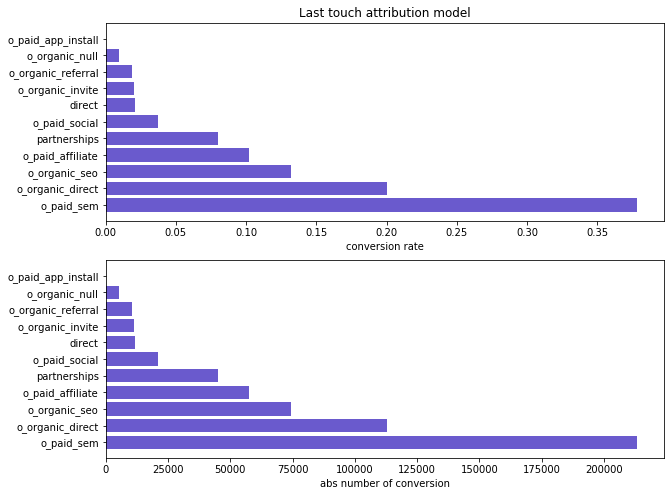

In [205]:
last_touch(basetable)

### Montly Basic

Visualization by percent stacked barplots by time?

In [263]:
basetable_m = last_touch_table_rm[['full_visitor_id','organization_uuid','ga_country','country_id','session_start_time','traffic_source']]

In [264]:
basetable_m = basetable_m.assign(year_month = basetable_m['session_start_time'].dt.to_period('M'))

In [340]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')
    

In [245]:
last_touch_m = last_touch_m(basetable_m)

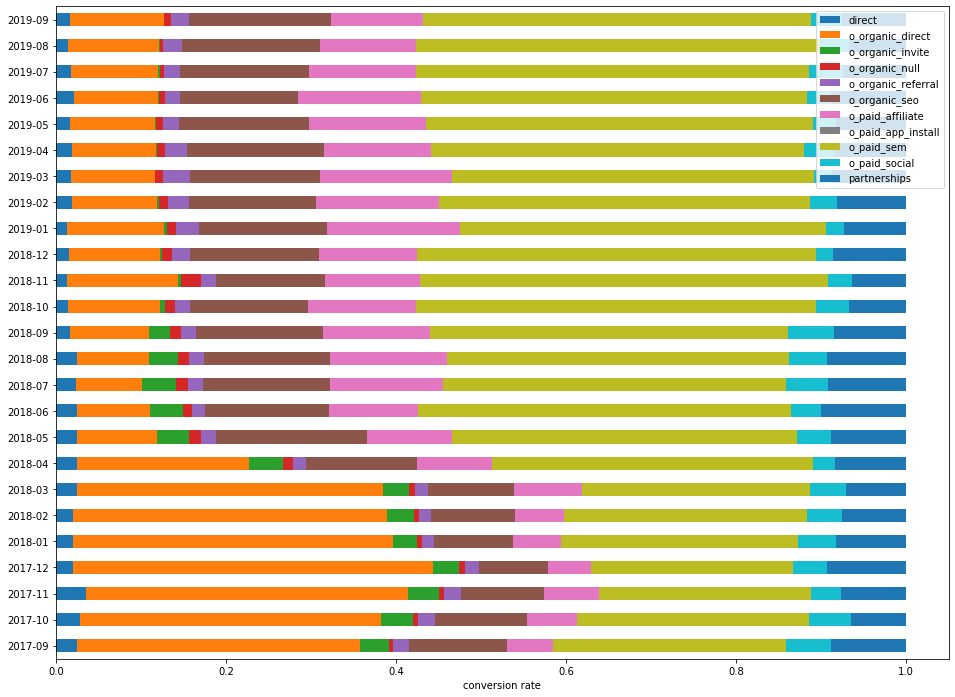

In [249]:
last_touch_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'upper right')
plt.show()

### By markets

In [265]:
for i in list(basetable_m.index):
    if pd.isna(basetable_m['country_id'].loc[i]):
        basetable_m.at[i, 'country_id'] = basetable_m['ga_country'].loc[i]

In [268]:
basetable_m[basetable_m['country_id'].isna()]

,full_visitor_id,organization_uuid,ga_country,country_id,session_start_time,traffic_source,year_month
574480,9175585403296116691,None,None,None,2017-09-13 17:50:11+00:00,o_paid_social,2017-09
118031,2674785224052520541,None,None,None,2017-11-28 10:11:36+00:00,o_organic_direct,2017-11
468527,7660068955542602524,None,None,None,2017-11-28 14:02:50+00:00,partnerships,2017-11
106759,2511281960897049072,None,None,None,2017-11-28 14:26:39+00:00,o_organic_seo,2017-11
299674,524948745723147624,None,None,None,2017-11-28 15:54:12+00:00,o_paid_affiliate,2017-11
...,...,...,...,...,...,...,...
81178,2148379906111824745,None,None,None,2018-01-19 12:27:20+00:00,partnerships,2018-01
392171,6572117653155083202,None,None,None,2018-01-19 21:44:37+00:00,o_organic_direct,2018-01
143268,3031244295326899480,None,None,None,2018-01-20 19:48:40+00:00,o_organic_direct,2018-01
111762,2583865112907839091,None,None,None,2018-01-22 05:28:25+00:00,o_organic_direct,2018-01


In [283]:
country_list = basetable_m.country_id.dropna().unique()

In [284]:
country_list

array(['BR', 'GB', 'FR', 'MX', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT',
       'SE'], dtype=object)

In [332]:
def last_touch_markets(df):
    for i in country_list:
        table = df[df['country_id'] == i]
        print(i)
        last_touch(table)

BR


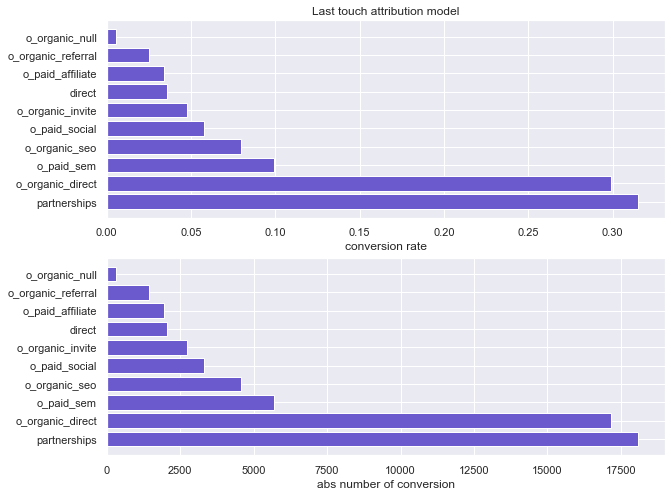

GB


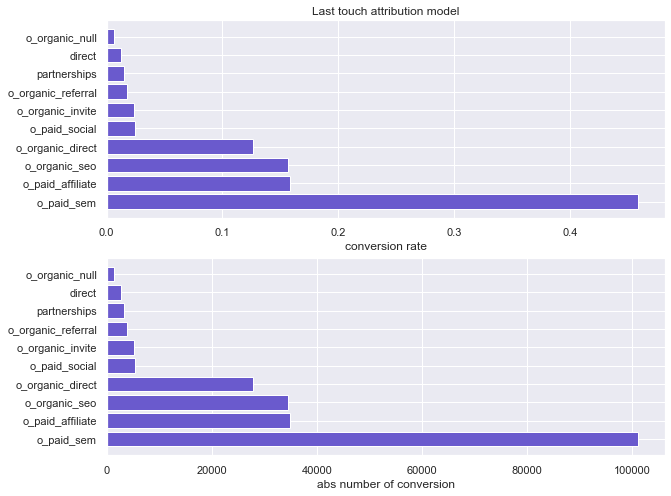

FR


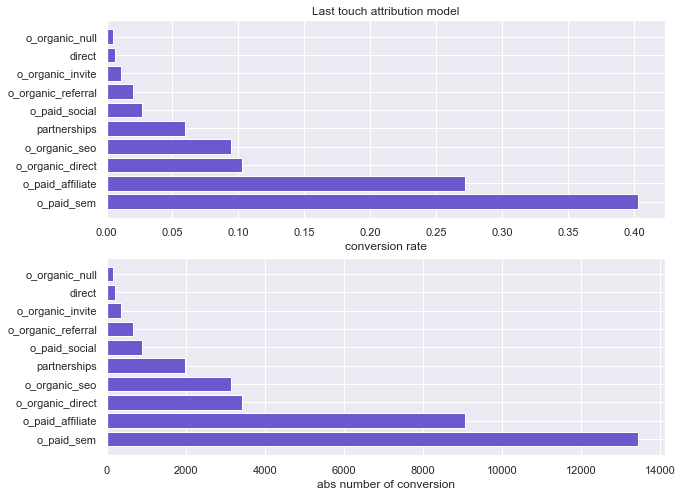

MX


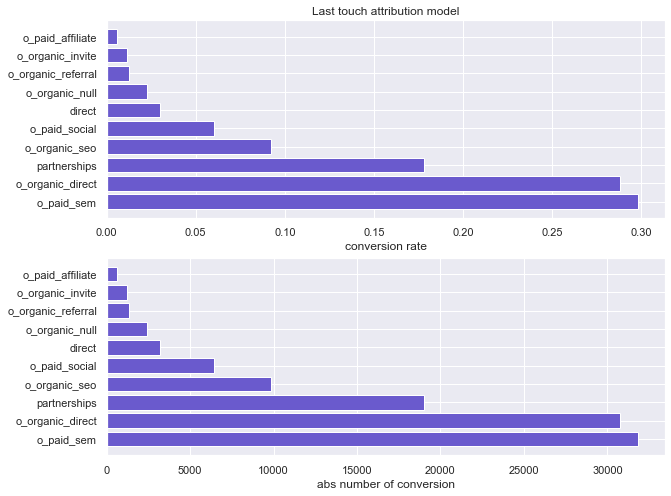

FI


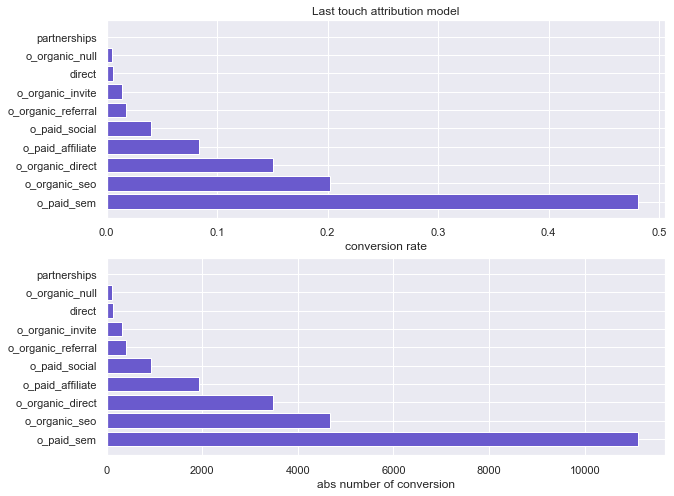

NO


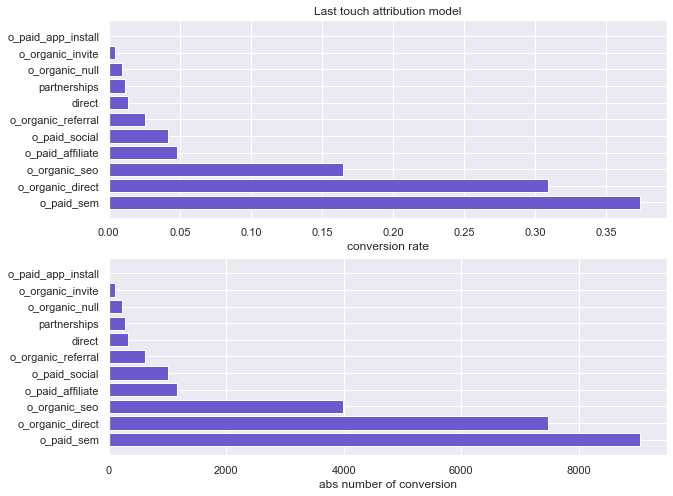

ES


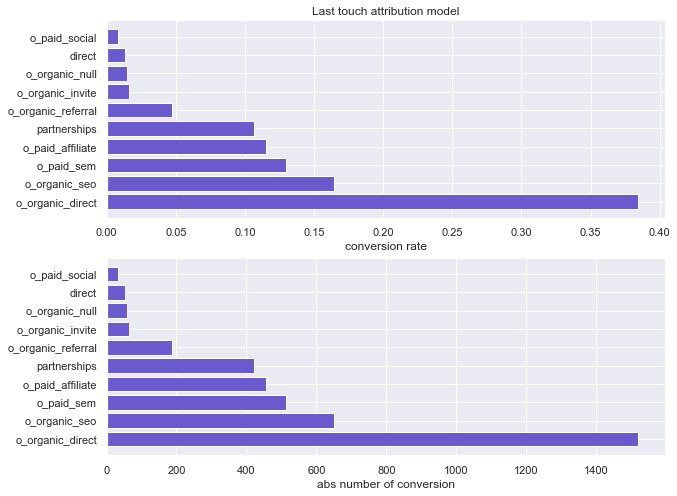

NL


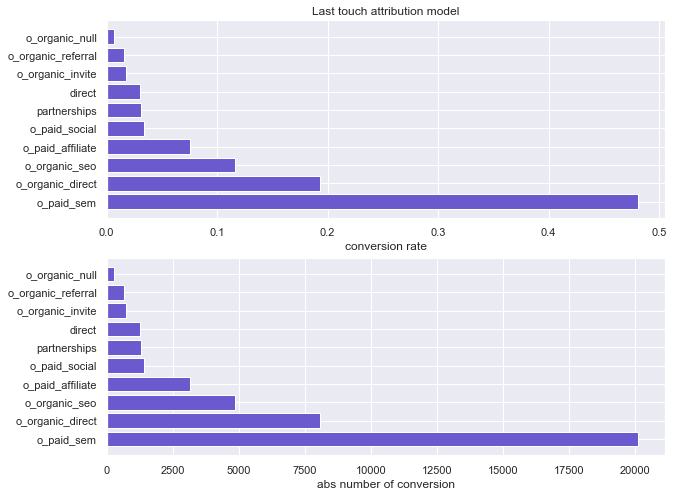

DE


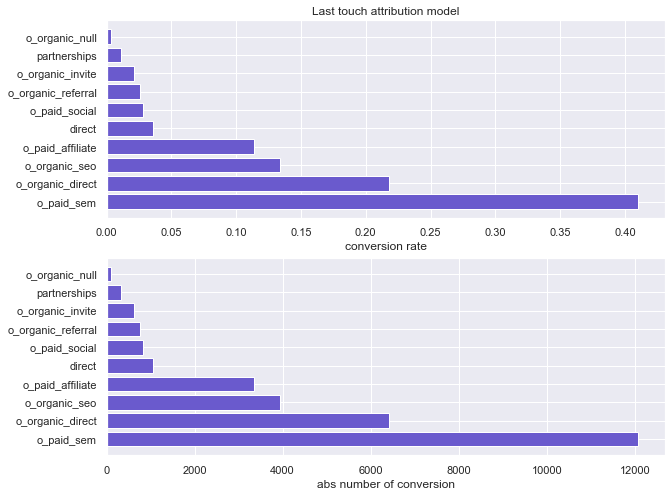

DK


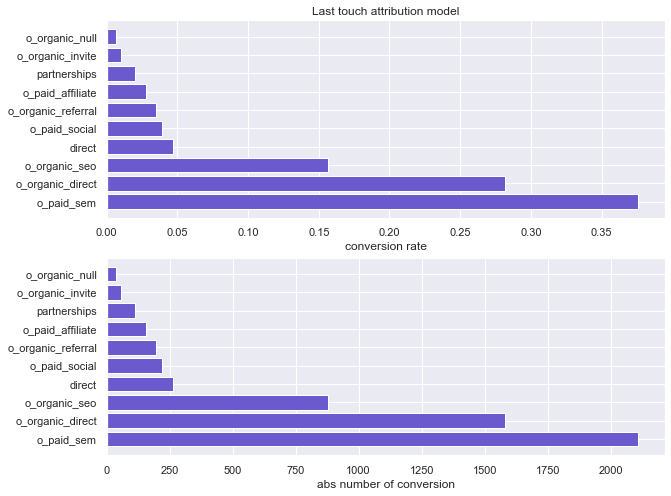

IT


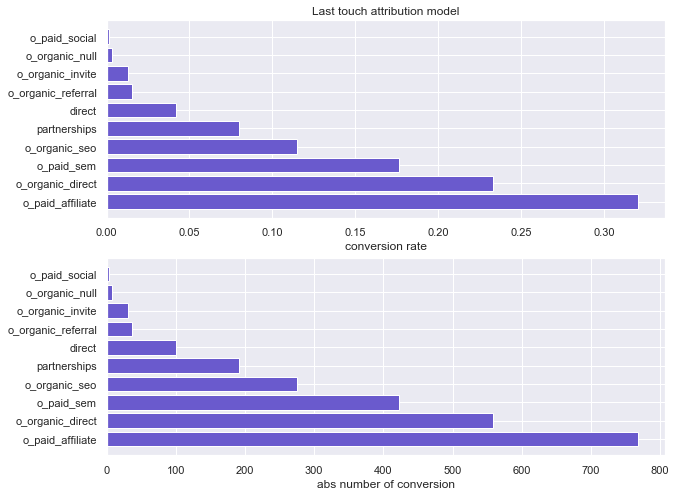

SE


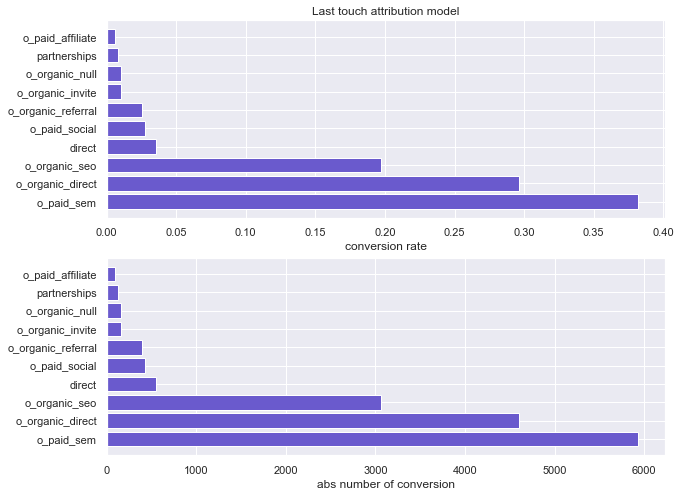

In [333]:
last_touch_markets(basetable_m)

In [295]:
basetable_m[basetable_m['country_id'] == 'BR'].shape

(57384, 7)

In [297]:
%%bigquery correct_data
SELECT 
  country_id,
  COUNT(DISTINCT organization_uuid ) as nr_merchant
FROM `izettle-dp-pipeline-prod.legacy_views.organization_customer` 
WHERE organization_created >= '2017-09-01'
GROUP BY country_id

In [310]:
ga_country_data = pd.DataFrame(basetable_m.groupby('country_id')['full_visitor_id'].count().reset_index())
ga_country_data.rename(columns = {'full_visitor_id':'ga_nr_merchant'}, inplace = True)

In [316]:
correct_ga = ga_country_data.merge(correct_data)

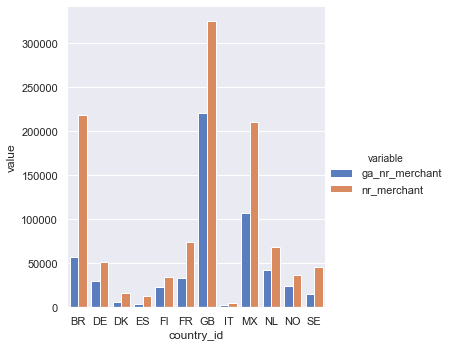

In [330]:
sbn.set(rc={'figure.figsize':(18,16)})
sbn.catplot(x="country_id", y="value", hue="variable", data=correct_ga.melt(id_vars = 'country_id'),
                kind="bar", palette="muted")
plt.show()

Missing a lot of data in BR market -> bias in last touch model for BR

### Markets and Monthly Basic

In [360]:
def last_touch_markets(df):
    for i in country_list:
        table = df[df['country_id'] == i]
        title = i
        
        last_touch = last_touch_m(table)
        
        pal = sbn.color_palette("tab20")
        last_touch.plot.barh(stacked = True,
                         rot = 0, colors = pal,
                         figsize = (14,10))
        plt.xlabel('conversion rate')
        plt.ylabel('')
        plt.xlabel('')
        plt.legend(loc = 'upper right')
        plt.title(title)
        plt.show()

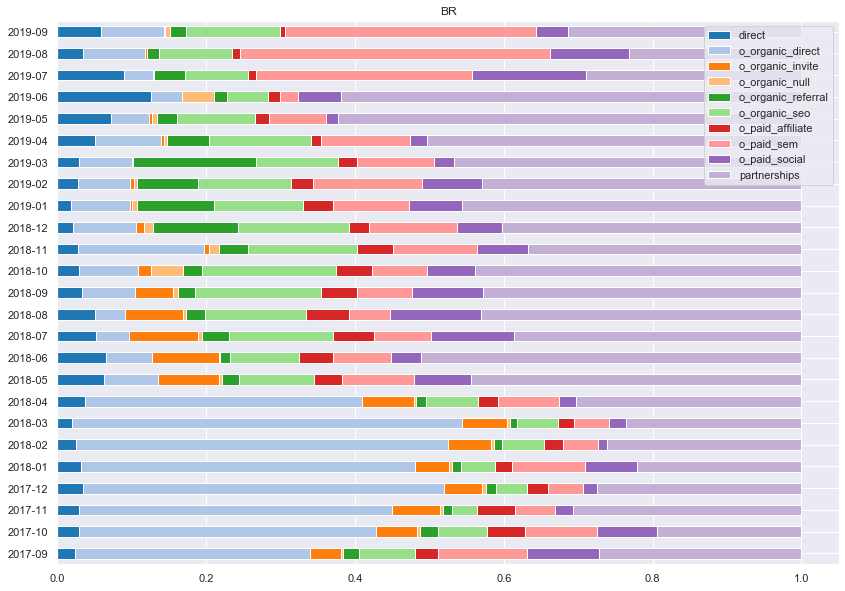

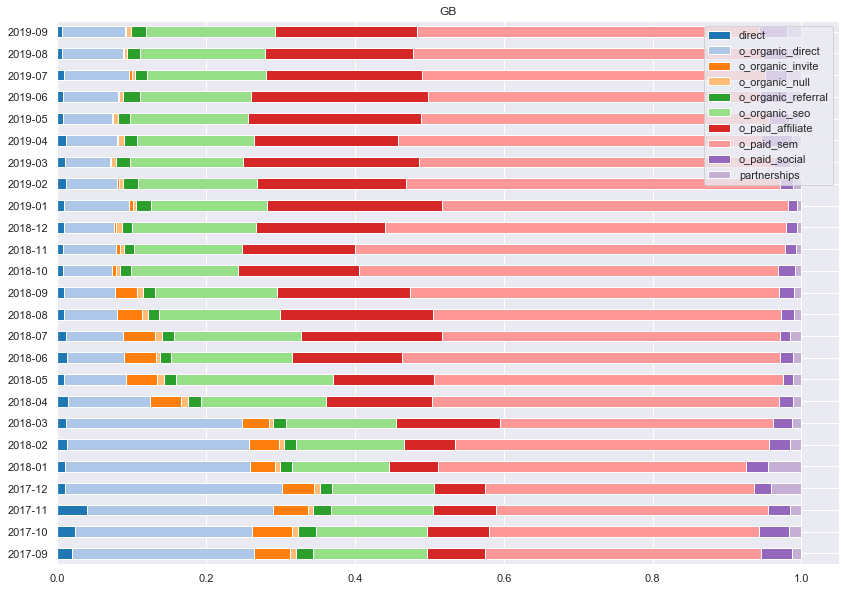

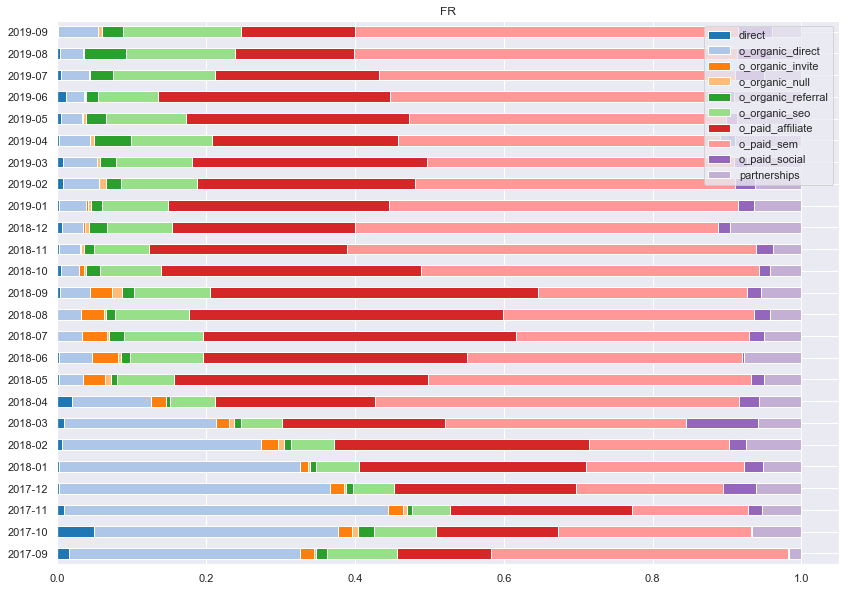

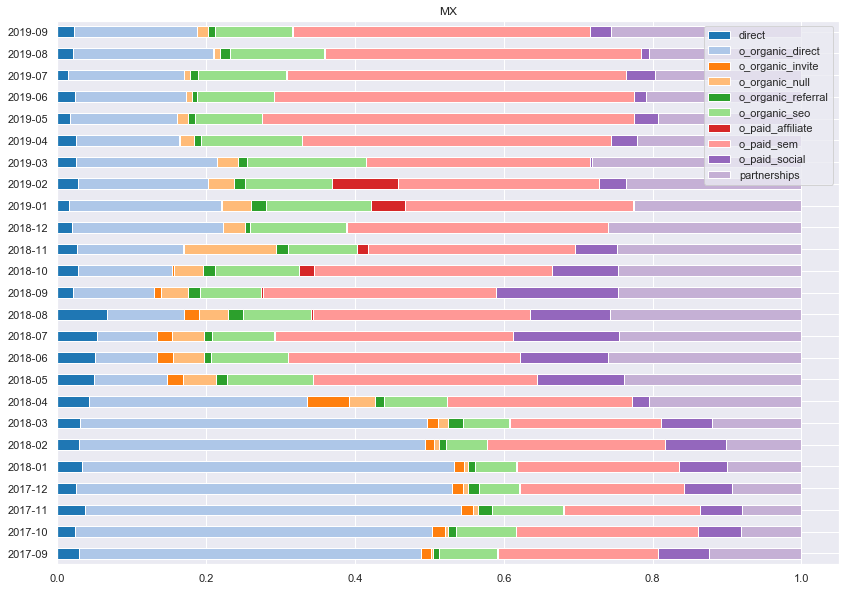

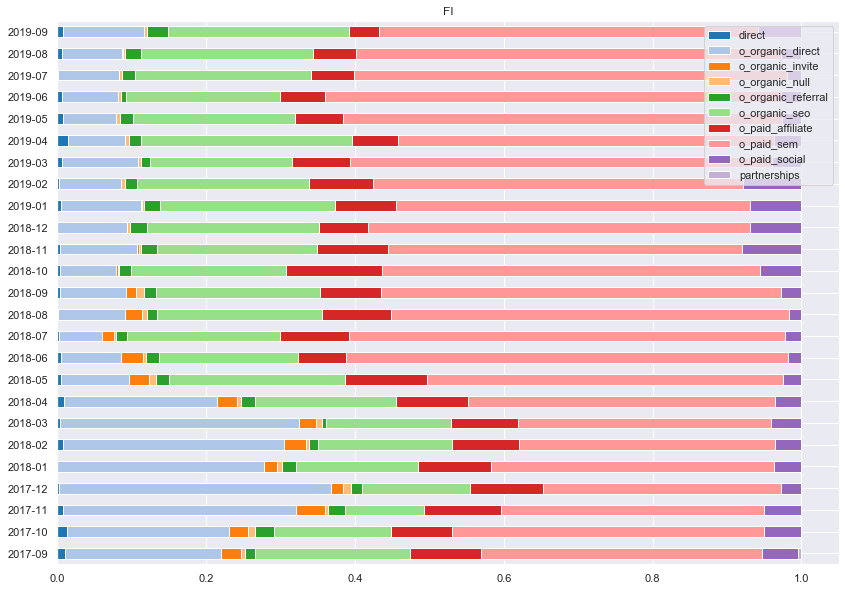

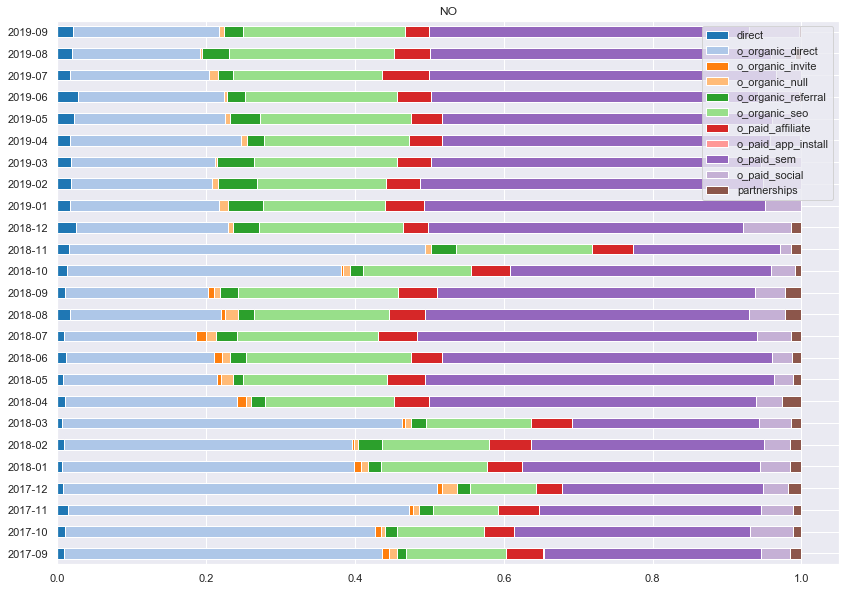

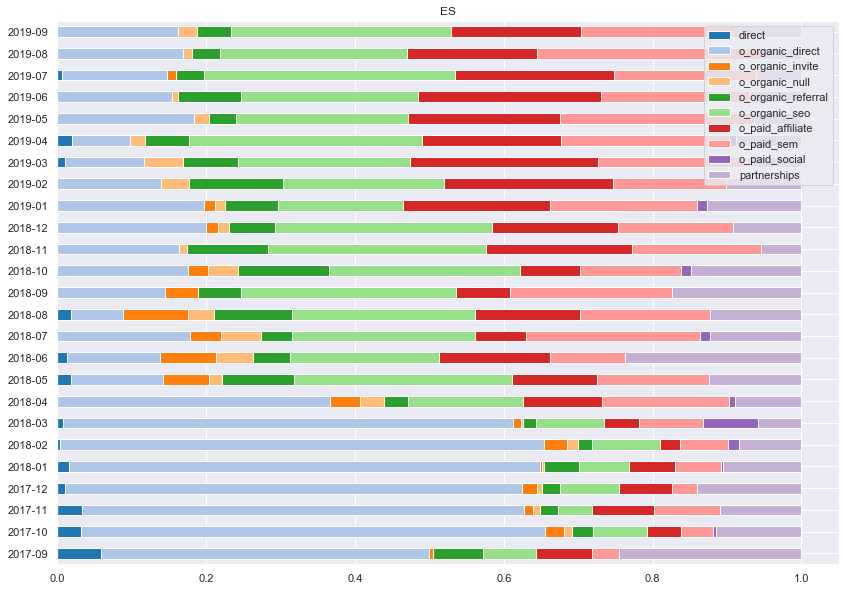

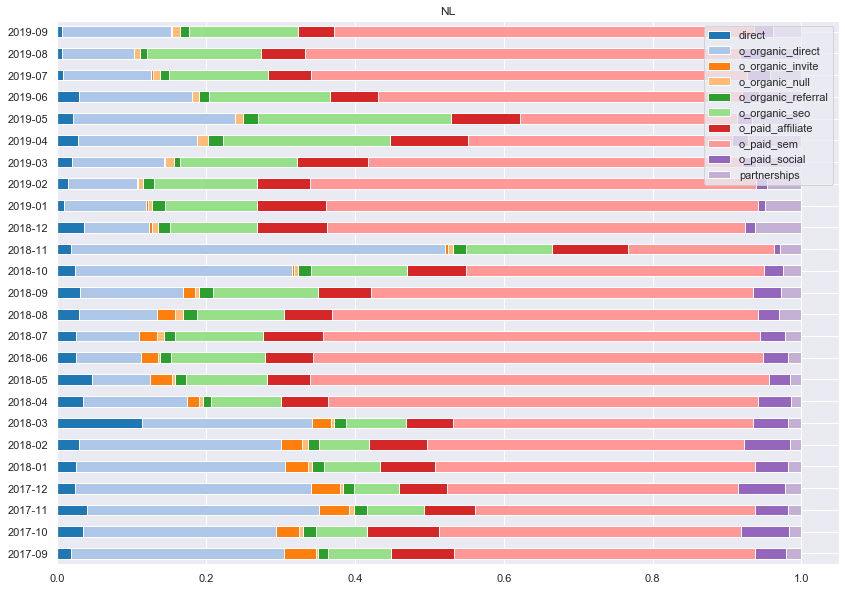

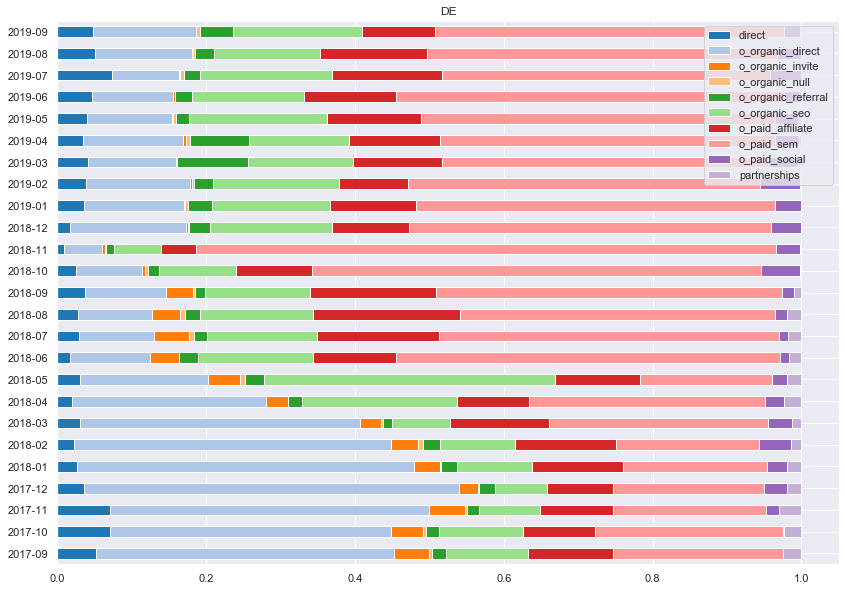

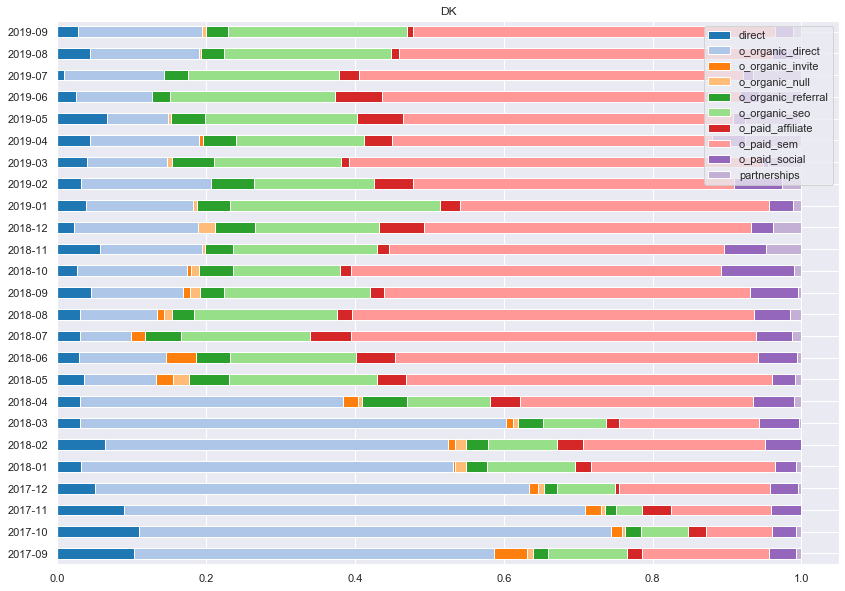

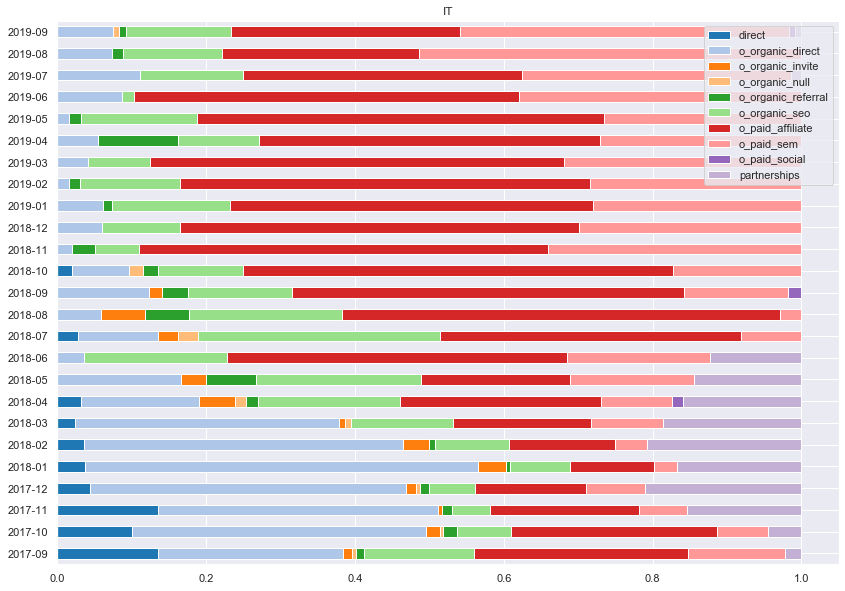

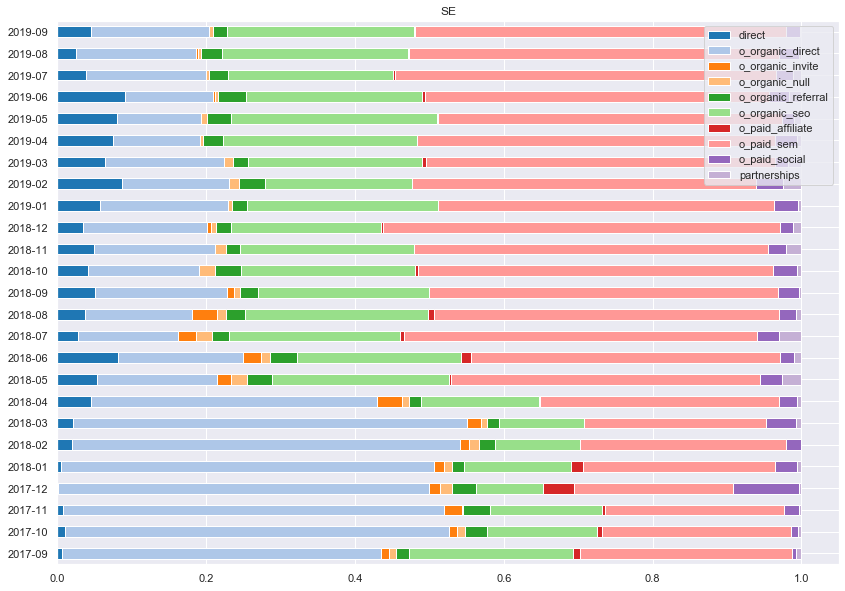

In [361]:
last_touch_markets(basetable_m)